# Multimodal Analysis and Classification of Environmental Audio Using Spectrogram Representations

This notebook focuses on classifying environmental sounds using spectrogram representations derived from audio signals. We will explore different preprocessing techniques, generate spectrograms, and train deep learning models (CNNs) for classification.

---

## 1. Setup and Imports

We begin by setting up the environment and importing the necessary libraries.


In [6]:
# Basic Libraries
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import os
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
# import IPython.display for playing audio in Jupter notebook
import IPython.display as ipd


# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import random 
SEED = 42
def seed_everything(seed=42): 
    random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed) 
seed_everything(SEED)

---

## 2. Load and Inspect Dataset

We will use the **UrbanSound8K** dataset, a popular environmental sound dataset with 10 categories such as air conditioner, car horn, children playing, and dog bark.

The dataset consists of:
- Audio clips (.wav files)
- A metadata file (`UrbanSound8K.csv`) containing file paths and labels

---


In [12]:
# Define dataset path
dataset_path = "../input/urbansound8k/"
metadata_path = "../input/urbansound8k/UrbanSound8K.csv"
all_files = []
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        all_files.append(os.path.join(path, name))
   
# Load metadata
metadata = pd.read_csv(metadata_path)
print("Metadata shape:", metadata.shape)
metadata.head()


Metadata shape: (8732, 8)


slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

## Urban Sound Dataset Column Names

* **slice_file_name**: The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
  * [fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
  * [classID] = a numeric identifier of the sound class
  * [occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
  * [sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* **fsID**: The Freesound ID of the recording from which this excerpt (slice) is taken

* **start**: The start time of the slice in the original Freesound recording 

* **end**: The end time of slice in the original Freesound recording

* **salience**: A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* **fold**: The fold number (1-10) to which this file has been allocated.

* **classID**: A numeric identifier of the sound class:
  * 0 = air_conditioner
  * 1 = car_horn
  * 2 = children_playing
  * 3 = dog_bark
  * 4 = drilling
  * 5 = engine_idling
  * 6 = gun_shot
  * 7 = jackhammer
  * 8 = siren
  * 9 = street_music

* **class**: The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music.

---

## 3. Explore Audio Samples

Before building models, it’s important to understand what the raw audio looks and sounds like. Here, we’ll:
- Pick a random audio sample
- Listen to it

---


In [13]:
# Pick a sample row (e.g., index 50) from metadata
file_base_path = '../input/urbansound8k'
sample_row = metadata.iloc[101]
file_name = sample_row['slice_file_name']
fold = sample_row['fold']
class_label = sample_row['class']
file_path = os.path.join(file_base_path, f"fold{fold}", file_name)

# Load audio file
signal, sr = librosa.load(file_path, sr=None)
duration = librosa.get_duration(y=signal, sr=sr)

print(f"Class: {class_label}")
print(f"Sampling Rate: {sr}")
print(f"Duration: {duration:.2f} seconds")

# Play the audio
ipd.Audio(signal, rate=sr)


Class: dog_bark
Sampling Rate: 44100
Duration: 0.53 seconds


---

## 4. Visualize Multiple Audio Samples

To better understand the diversity of environmental sounds in the dataset, we randomly select 9 audio clips and visualize their waveforms. Each subplot corresponds to a unique class label (e.g., dog bark, siren, etc.).

This helps in observing:
- The varying amplitude patterns across classes
- The length and structure of sounds
---


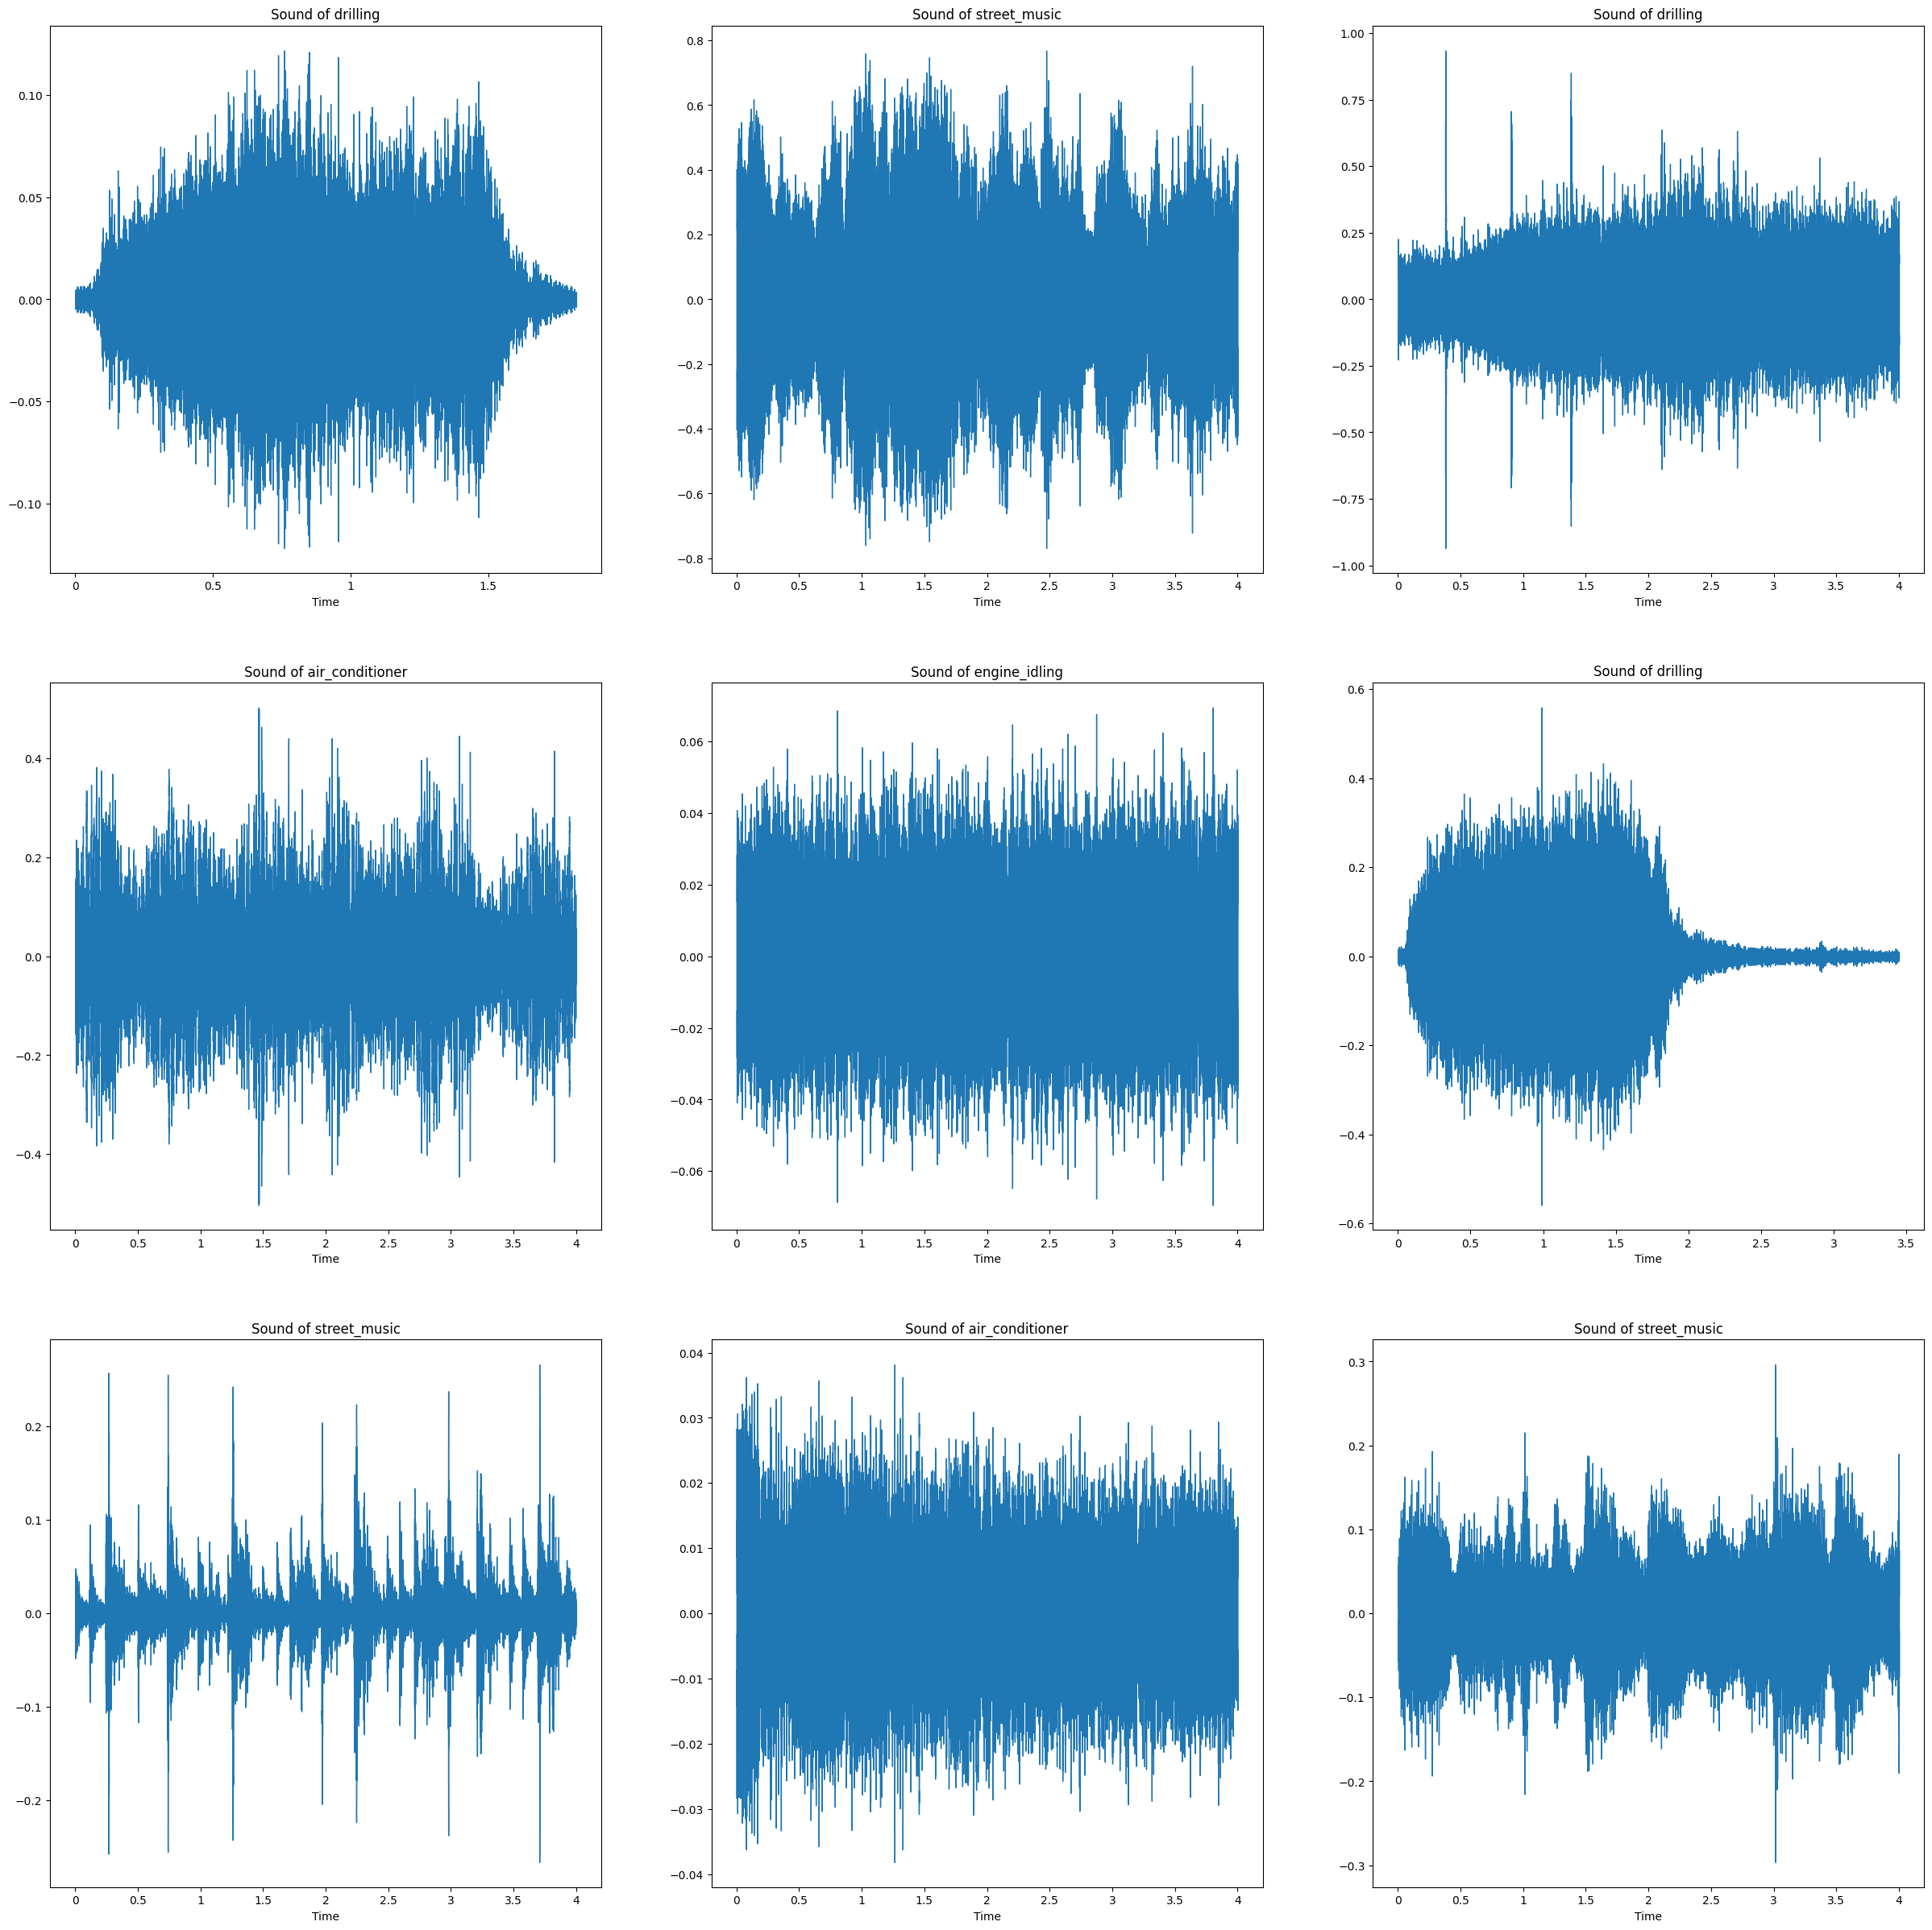

In [14]:
plot_files = random.choices(all_files, k=10)
plot_audios = [librosa.load(plot_files[i]) for i in range(10)]

# Extract class names from filenames
class_names = []
for file_path in plot_files:
    # Get just the filename without the directory path
    filename = os.path.basename(file_path)
    # Extract the class ID (second element in the filename)
    class_id = int(filename.split('-')[1])
    # Map class ID to class name using your metadata or this mapping
    class_mapping = {
        0: "air_conditioner",
        1: "car_horn",
        2: "children_playing",
        3: "dog_bark",
        4: "drilling",
        5: "engine_idling",
        6: "gun_shot",
        7: "jackhammer",
        8: "siren", 
        9: "street_music"
    }
    class_name = class_mapping[class_id]
    class_names.append(class_name)

plt.figure(figsize=(30, 30))
for i in range(9):  # Changed from range(1,10) to range(9) for 0-indexed plotting
    plt.subplot(3, 3, i+1)  # i+1 because subplot indices start at 1
    librosa.display.waveshow(plot_audios[i][0])
    plt.title(f"Sound of {class_names[i]}")

# Distribution of Categories

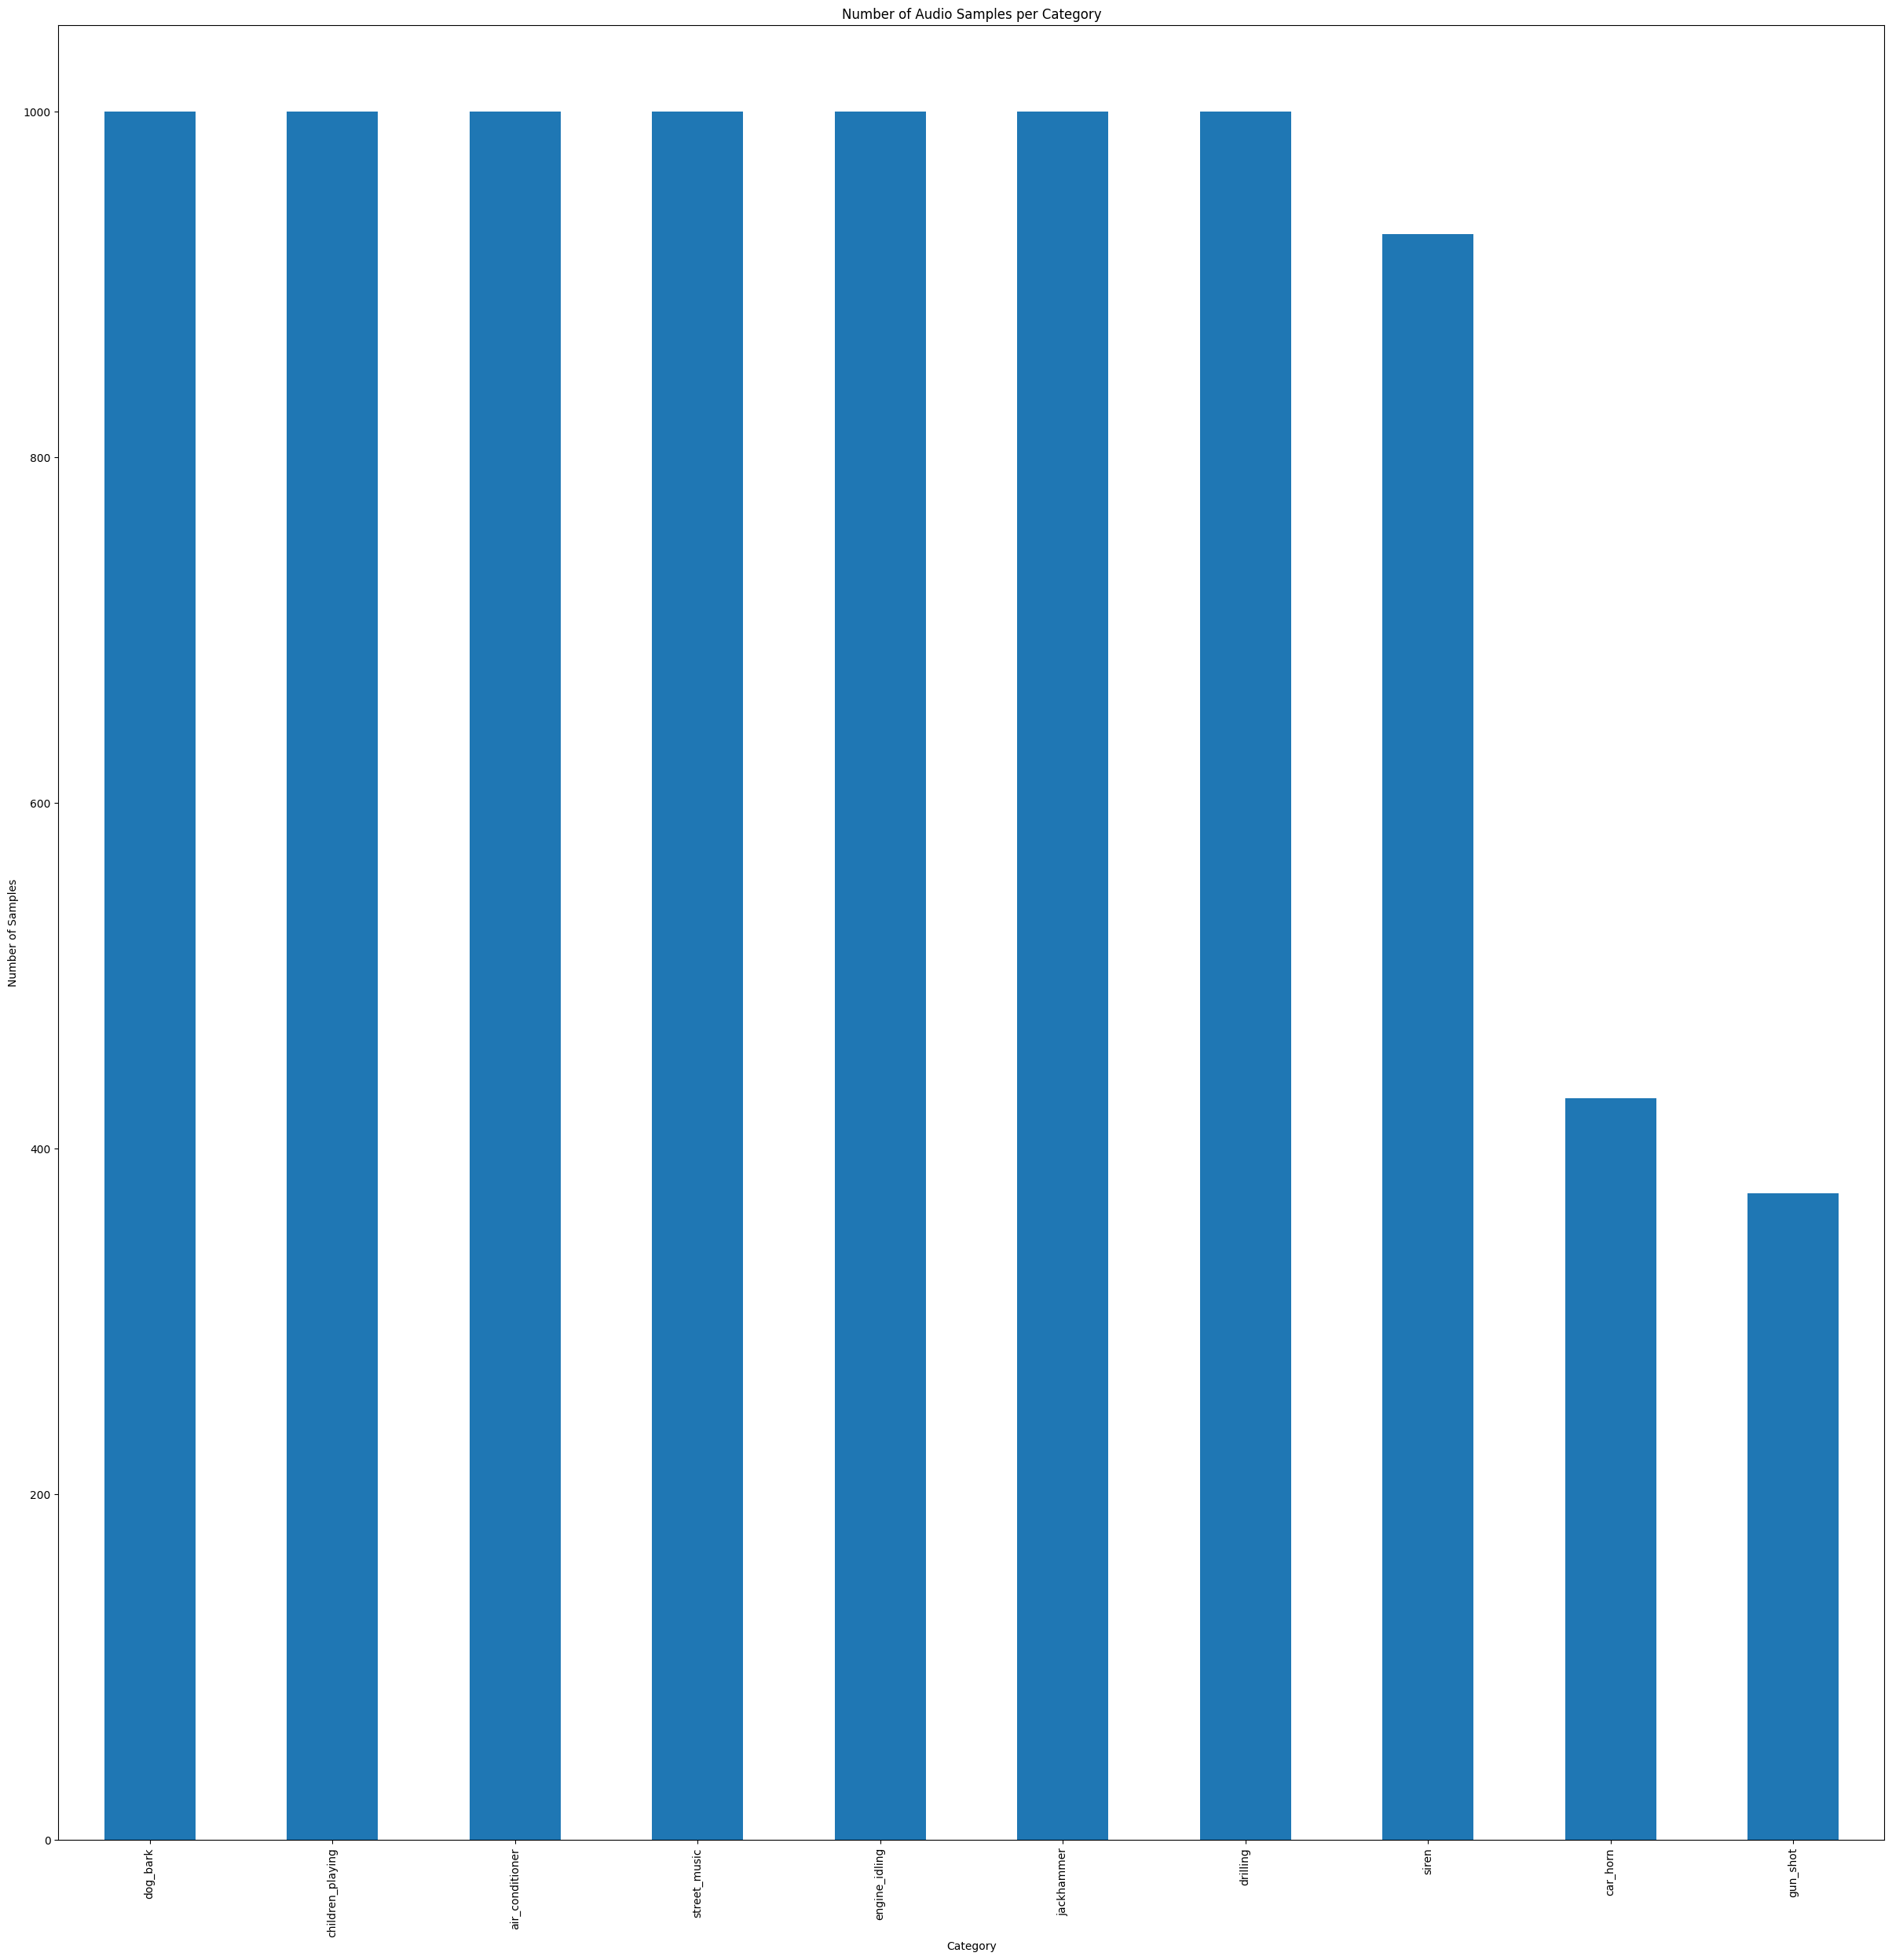

In [15]:
category_group = metadata['class'].value_counts()
plot = category_group.plot(kind='bar', title="Number of Audio Samples per Category", figsize=(30,30))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

# Spectrogram

A spectrogram is a time-frequency representation of a signal, such as an audio signal. It is a graphical representation of the frequency content of a signal over time, and is often used to visualize and analyze audio signals.

A spectrogram is typically represented as a 2D image, with the x-axis representing time, the y-axis representing frequency, and the intensity of the color or grayscale representing the amplitude of the frequency component at that point in time.

The spectrogram is calculated by applying the Short-Time Fourier Transform (STFT) to the audio signal, which breaks the audio into short segments and applies the Fourier transform to each segment. This produces a set of complex numbers representing the frequency content of the audio for each segment, which are then plotted in the spectrogram.

A spectrogram can be useful for visualizing the frequency content of a sound over time, and for identifying patterns in the audio signal, such as pitch, timbre, and transient events. It can also be used to analyze the characteristics of different sounds, such as the spectral envelope or the harmonic structure, and to segment an audio file into different sound events.

A spectrogram can be used in many audio-related tasks, such as speech recognition, audio source separation, and audio event detection, and it is an essential tool in the field of audio signal processing.

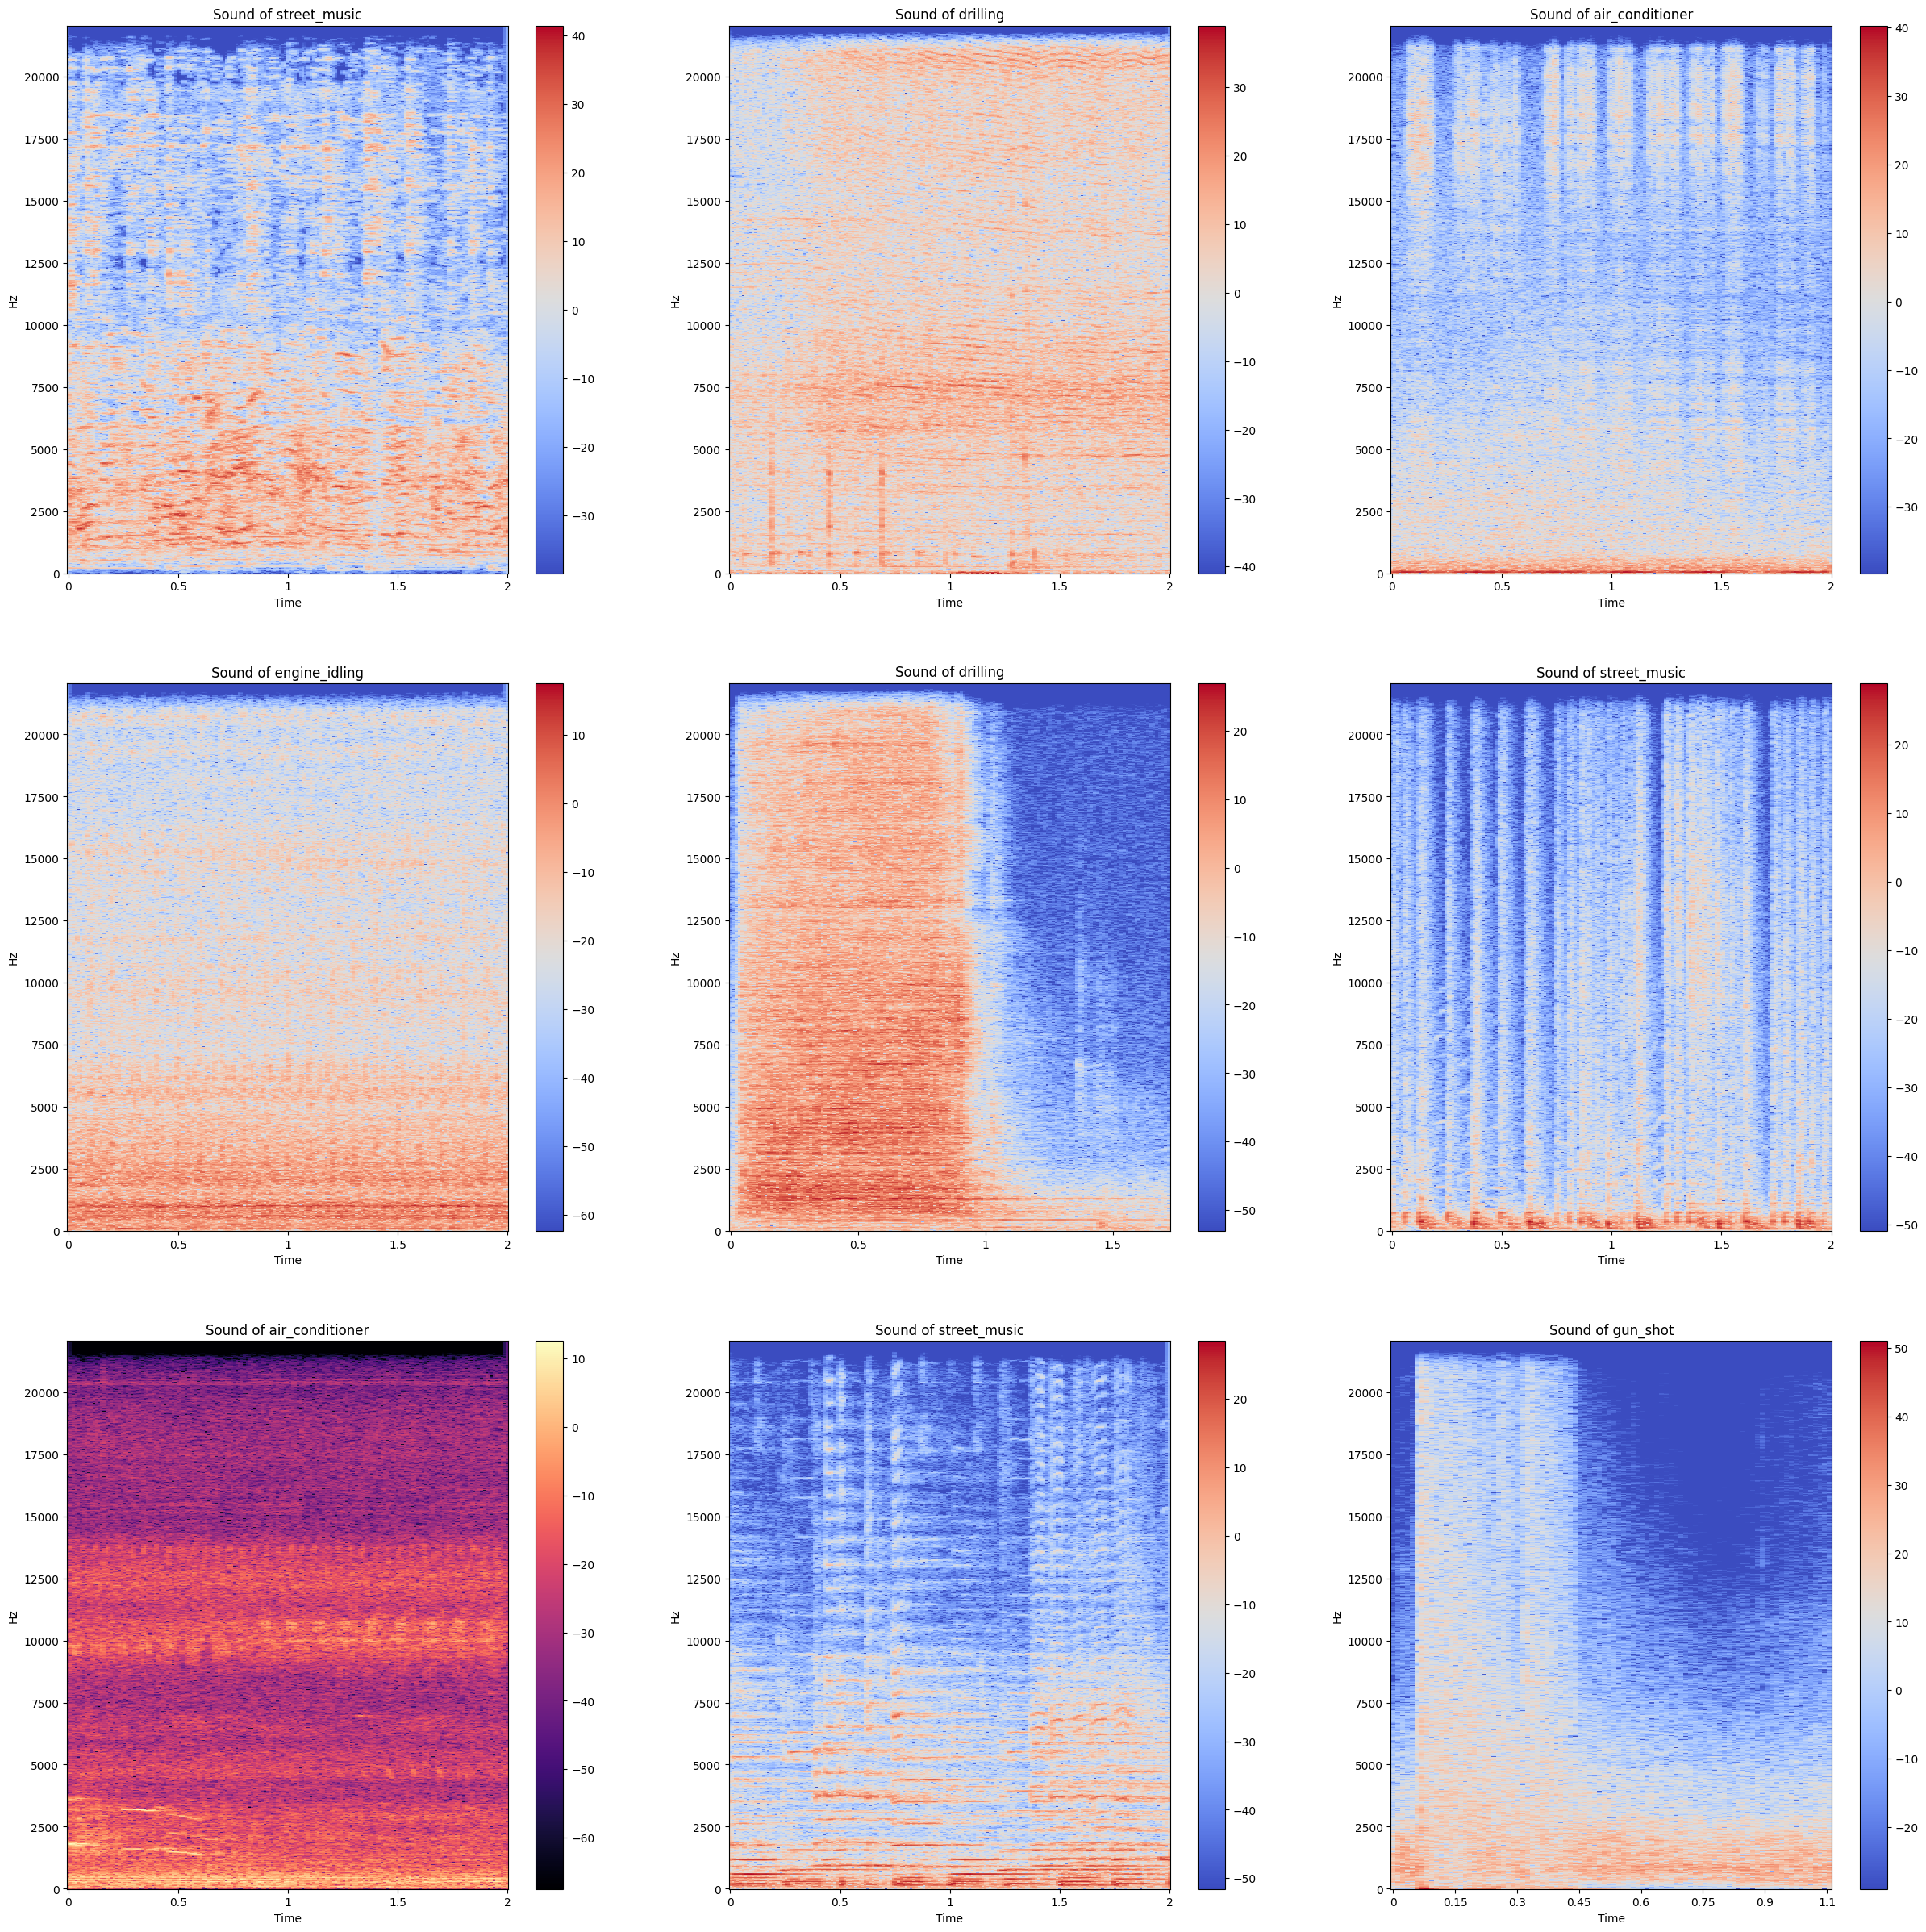

In [16]:
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    X = librosa.stft(plot_audios[i][0])
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f"Sound of {class_names[i]}")

# 1. The Mel Scale
Studies have shown that humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. For example, we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell a difference between 10,000 and 10,500 Hz, even though the distance between the two pairs are the same.

2. The Mel Spectrogram
A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.

A mel spectrogram logarithmically renders frequencies above a certain threshold (the corner frequency). For example, in the linearly scaled spectrogram, the vertical space between 1,000 and 2,000Hz is half of the vertical space between 2,000Hz and 4,000Hz. In the mel spectrogram, the space between those ranges is approximately the same. This scaling is analogous to human hearing, where we find it easier to distinguish between similar low frequency sounds than similar high frequency sounds.

A mel spectrogram computes its output by multiplying frequency-domain values by a filter bank.

---

## 5. Visualize Mel-Spectrograms of Multiple Samples

Here, we plot the **Mel-spectrograms** for the same 9 randomly selected audio clips. Mel-spectrograms transform audio into the time-frequency domain, which is more suitable for machine learning models, especially convolutional neural networks (CNNs).

Each plot shows the sound's energy distribution over time and frequency bands, giving insights into the unique patterns across different classes.

---


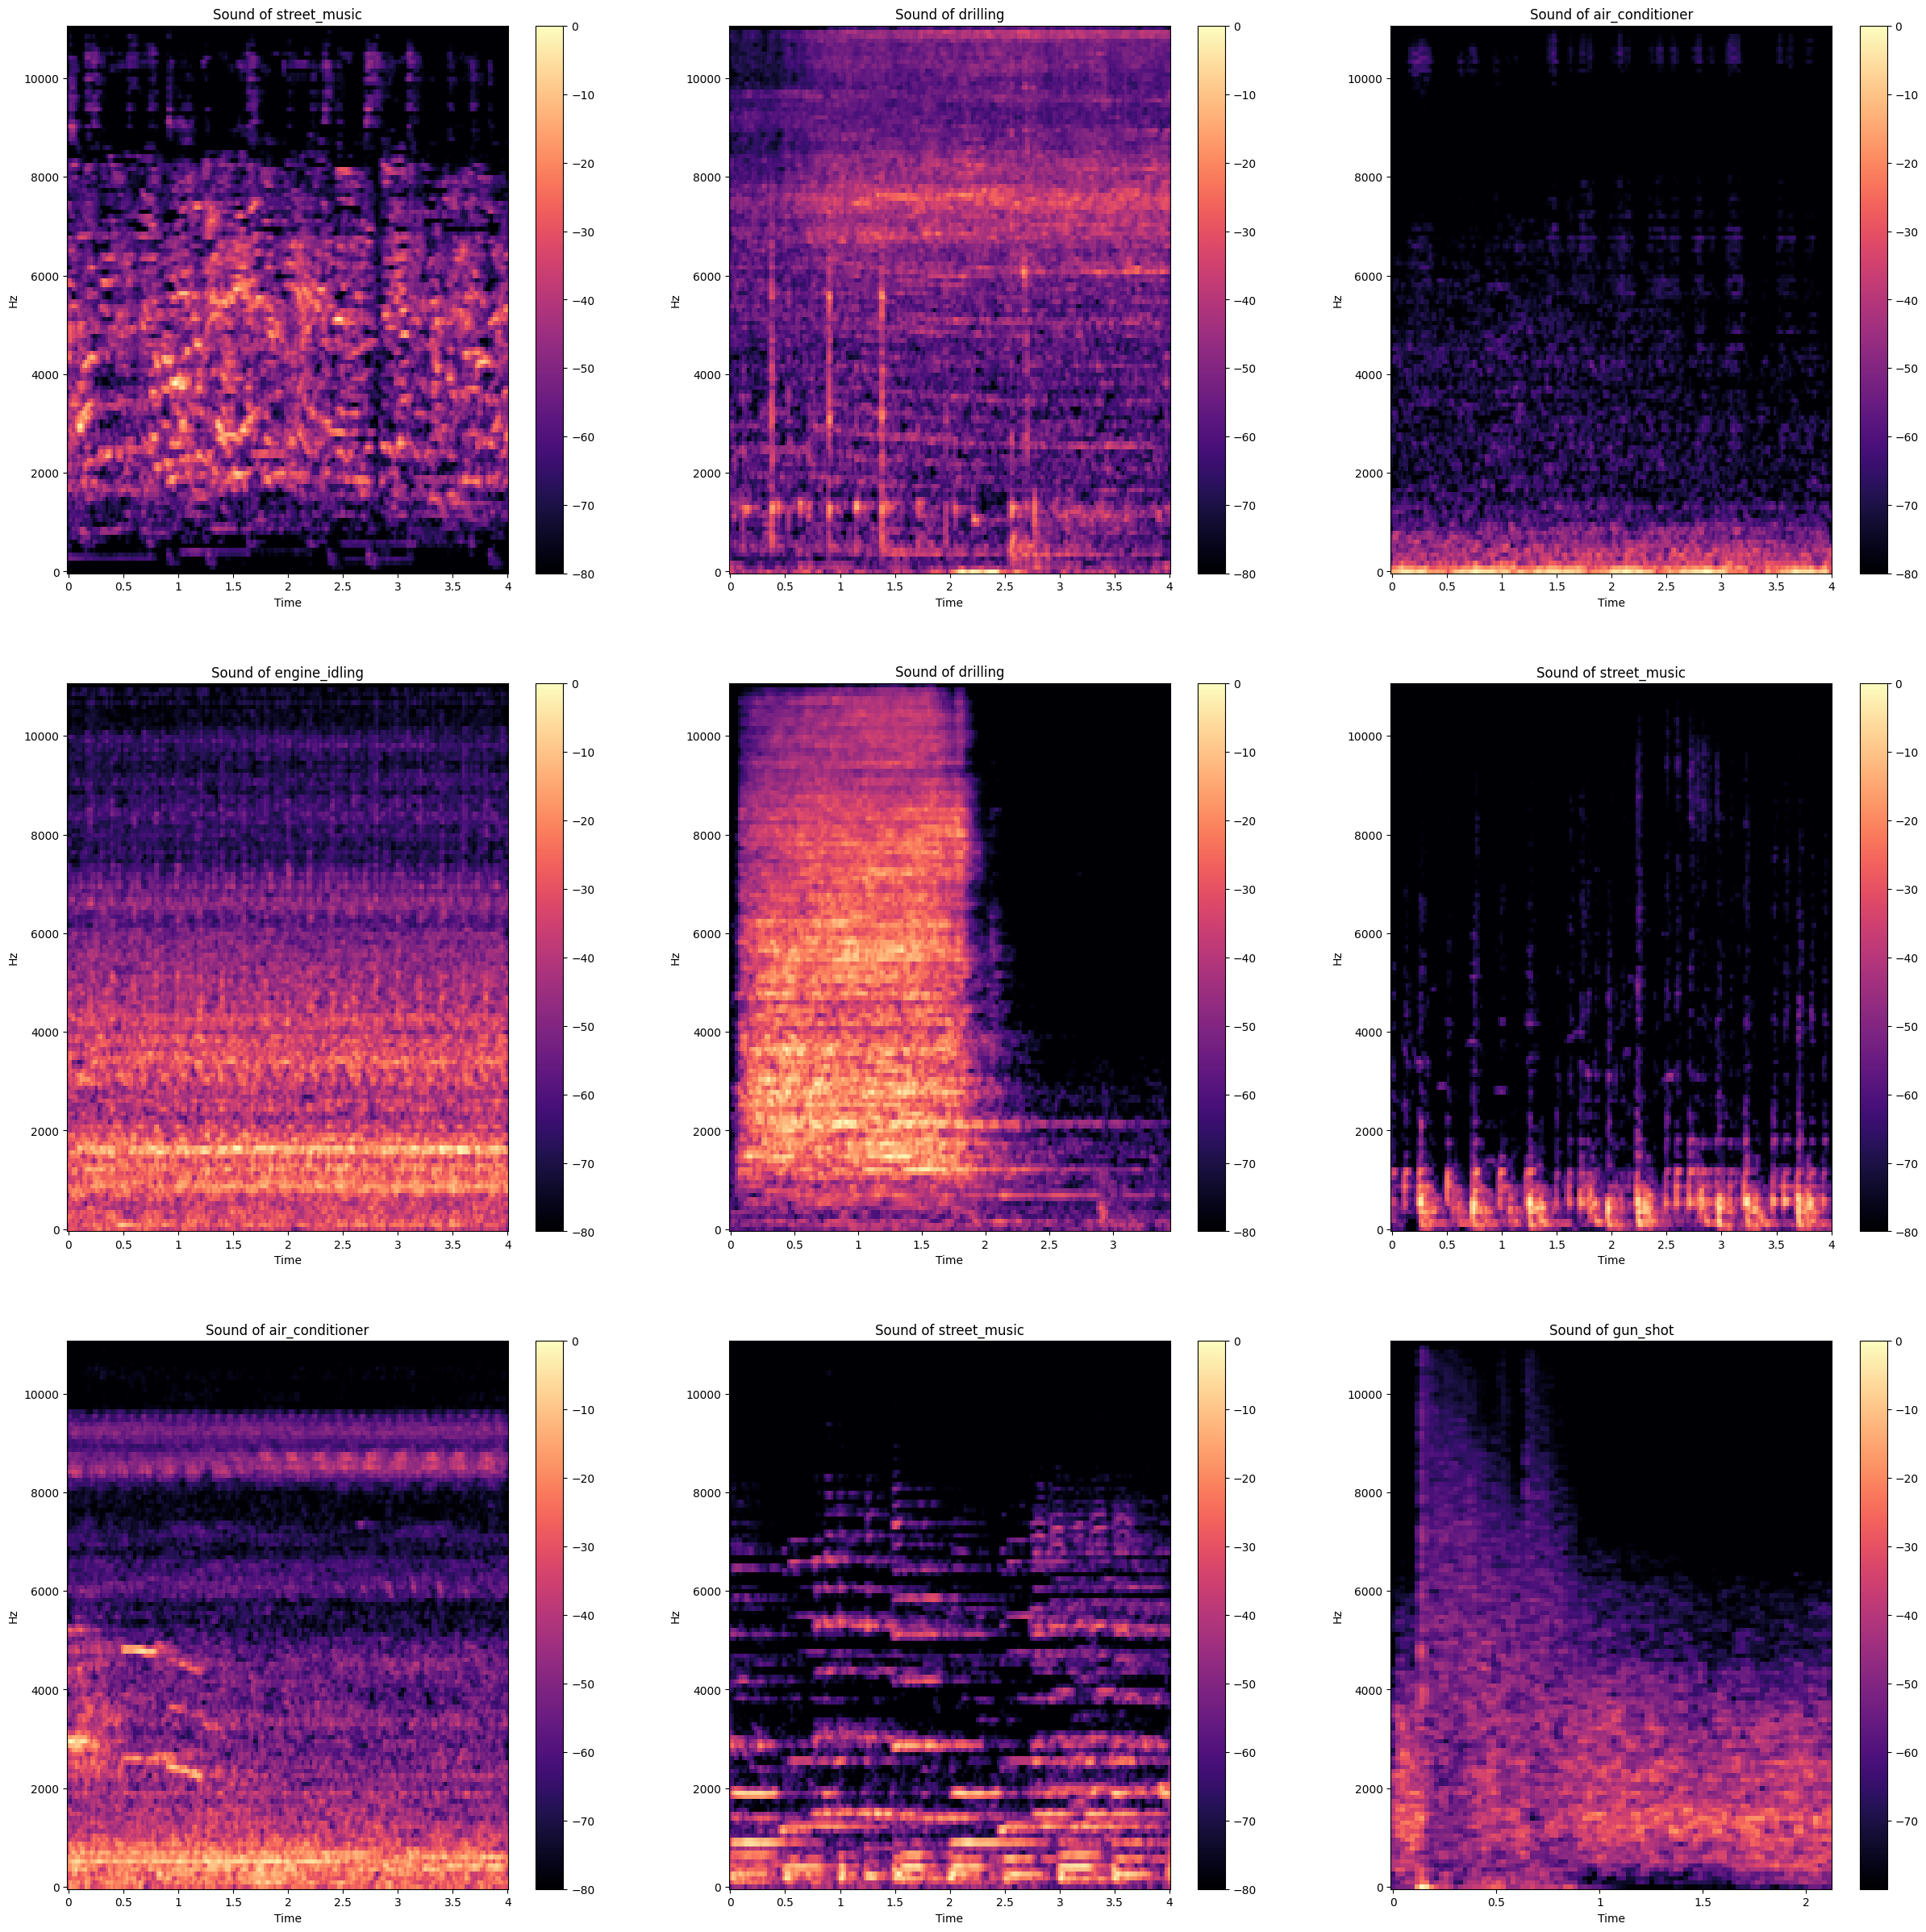

In [17]:
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    X, _ = librosa.effects.trim(plot_audios[i][0])
    XS = librosa.feature.melspectrogram(y=X, sr=plot_audios[i][1])
    
    Xdb = librosa.amplitude_to_db(XS, ref=np.max)
    librosa.display.specshow(Xdb, sr=plot_audios[i][1], x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f"Sound of {class_names[i]}")

---

## 6. Generate and Save Spectrogram Images

To prepare the dataset for model training, we convert each audio file into a **Mel-spectrogram image** and save it in a structured directory:



In [ ]:
# Directory to save spectrograms
output_dir = "./spectrogram_data"
os.makedirs(output_dir, exist_ok=True)

def save_spectrogram(signal, sr, save_path):
    # Create Mel-spectrogram and convert to dB
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Save the spectrogram without axes
    plt.figure(figsize=(3, 3))
    librosa.display.specshow(mel_db, sr=sr, x_axis=None, y_axis=None)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Iterate through all rows in metadata
for i, row in tqdm(metadata.iterrows(), total=len(metadata)):
    class_id = row["classID"]
    class_name = row["class"]
    fold = row["fold"]
    file_name = row["slice_file_name"]
    
    file_path = os.path.join(dataset_path, f"fold{fold}", file_name)
    
    try:
        signal, sr = librosa.load(file_path, sr=None)
        class_folder = os.path.join(output_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)
        
        # Save path
        save_path = os.path.join(class_folder, file_name.replace('.wav', '.png'))
        save_spectrogram(signal, sr, save_path)
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")


100%|██████████| 8732/8732 [20:54<00:00,  6.96it/s]  


---

## 7. Load Spectrogram Images for Classification 

Now that we have Mel-spectrogram images saved and organized by class, we load them using PyTorch’s `ImageFolder`. We'll:

- Resize and normalize the images
- Split the data into training and validation sets
- Create PyTorch `DataLoader`s for easy batch processing

This step prepares the dataset for feeding into a CNN-based model.

---


In [19]:
output_dir = "./spectrogram_data"

# Define transforms (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming grayscale
])

# Load dataset
dataset = datasets.ImageFolder(root=output_dir, transform=transform)

# Split into training and validation sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class labels
class_names = dataset.classes
print("Classes:", class_names)


Classes: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


---

## 8. Build a CNN for Spectrogram Classification

Now we define a Convolutional Neural Network (CNN) to classify Mel-spectrogram images into environmental sound classes.

Key steps:
- Define the architecture using `nn.Module`
- Use ReLU activations and MaxPooling
- Add a final fully connected layer matching the number of classes

This model will be trained using cross-entropy loss and an optimizer like Adam.

---


In [20]:
import torch.nn as nn
import torch.nn.functional as F

class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate model
model = SpectrogramCNN(num_classes=len(class_names)).to(device)
print(model)


SpectrogramCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


---

## 9. Train the CNN Model

We now train our CNN model using the spectrogram image dataset. We'll use:
- **CrossEntropyLoss** for classification
- **Adam optimizer** for efficient learning
- Training for a few epochs with real-time feedback on loss and accuracy

This will allow the model to learn the unique spectro-temporal patterns of different sound classes.

---


In [22]:
import os
import torch.optim as optim
from tqdm import tqdm

# Checkpoint path
checkpoint_path = 'model_checkpoint.pth'

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load checkpoint if exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    print("Found existing checkpoint, loading weights...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # resume from next epoch
    print(f"Resuming from epoch {start_epoch + 1}...")

# Training loop
num_epochs = 8
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_pbar.set_postfix({
            'loss': f"{running_loss/total:.4f}", 
            'acc': f"{100*correct/total:.2f}%"
        })

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")

    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_pbar.set_postfix({
                'loss': f"{val_loss/total_val:.4f}", 
                'acc': f"{100*correct_val/total_val:.2f}%"
            })

    val_acc = 100 * correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Acc: {val_acc:.2f}%")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f" Checkpoint saved for epoch {epoch+1}.")


/tmp/ipykernel_31/1350473826.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Found existing checkpoint, loading weights...
Resuming from epoch 7...


Epoch 7/8 [Valid]: 100%|██████████| 41/41 [00:09<00:00,  4.49it/s, loss=0.0011, acc=99.16%]


Epoch [7/8] - Train Loss: 0.0860, Train Acc: 97.28%, Val Loss: 0.0338, Val Acc: 99.16%
 Checkpoint saved for epoch 7.


Epoch 8/8 [Valid]: 100%|██████████| 41/41 [00:09<00:00,  4.49it/s, loss=0.0010, acc=98.85%]


Epoch [8/8] - Train Loss: 0.0576, Train Acc: 98.30%, Val Loss: 0.0332, Val Acc: 98.85%
 Checkpoint saved for epoch 8.


### Model Evaluation on Test Set

After completing training and validation over the defined number of epochs, we evaluate the model's performance on the unseen test set. This provides a final estimate of the model's generalization ability.

The testing loop involves:
- Switching the model to evaluation mode to disable dropout/batchnorm updates.
- Running inference on the test set without gradient calculations for efficiency.
- Computing the test loss and accuracy.

The test results are printed at the end, showing the model's overall performance.


In [ ]:
# Load the full checkpoint
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Optional: only needed if you plan to resume training
model.eval()

# Evaluation on test set
test_loss = 0.0
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

test_pbar = tqdm(test_loader, desc="Testing Model")
with torch.no_grad():
    for images, labels in test_pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_pbar.set_postfix({
            'loss': f"{test_loss/total_test:.4f}",
            'acc': f"{100*correct_test/total_test:.2f}%"
        })

final_test_acc = 100 * correct_test / total_test
print(f"Final Test Accuracy: {final_test_acc:.2f}%, Test Loss: {test_loss/len(test_loader):.4f}")


/tmp/ipykernel_31/2595706079.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_checkpoint.pth')
Testing Model: 100%|██████████| 41/41 [00:09

Final Test Accuracy: 98.93%, Test Loss: 0.0496


## Model Evaluation: Confusion Matrix & Classification Report

To further analyze the model's performance across all environmental sound classes, we use a confusion matrix and a classification report:

- **Confusion Matrix** gives insight into which classes are being misclassified the most.
- **Classification Report** provides precision, recall, and F1-score for each class.

These metrics help in identifying which classes the model struggles with and where improvements can be made, especially in imbalanced or similar-sounding categories.


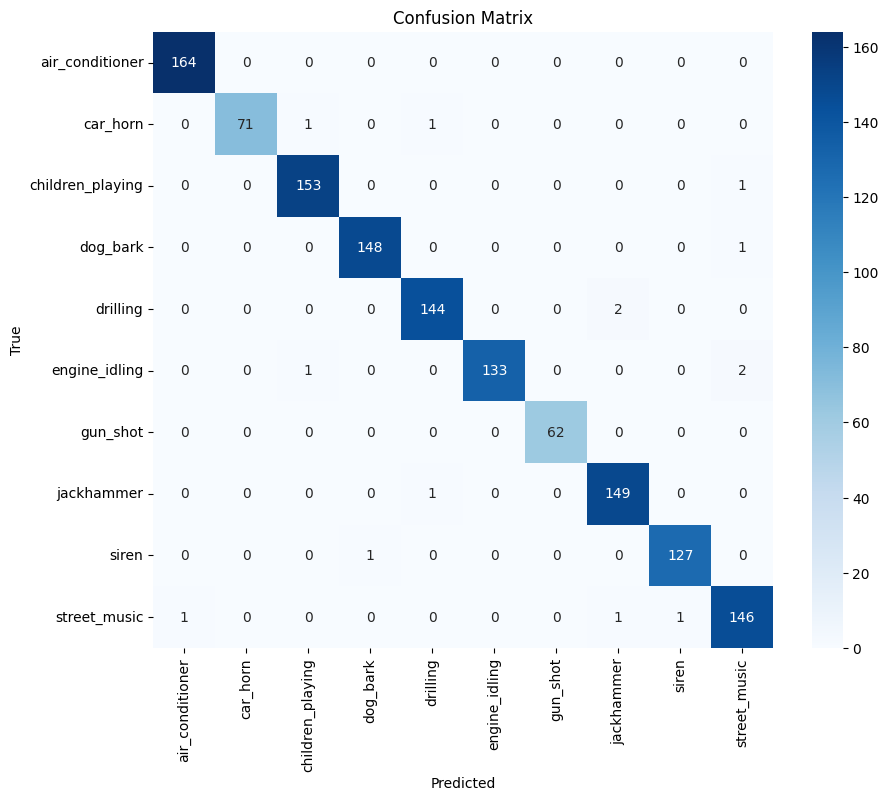

Classification Report:
                   precision    recall  f1-score   support

 air_conditioner       0.99      1.00      1.00       164
        car_horn       1.00      0.97      0.99        73
children_playing       0.99      0.99      0.99       154
        dog_bark       0.99      0.99      0.99       149
        drilling       0.99      0.99      0.99       146
   engine_idling       1.00      0.98      0.99       136
        gun_shot       1.00      1.00      1.00        62
      jackhammer       0.98      0.99      0.99       150
           siren       0.99      0.99      0.99       128
    street_music       0.97      0.98      0.98       149

        accuracy                           0.99      1311
       macro avg       0.99      0.99      0.99      1311
    weighted avg       0.99      0.99      0.99      1311



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)
